1. Import Necessary Libraries

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import random

2. Data Loading and Preprocessing

In [2]:
class BinaryCIFAR10(Dataset):
    def __init__(self, cifar10_dataset, target_class):
        self.cifar10_dataset = cifar10_dataset
        self.target_class = target_class
        self.class_to_idx = cifar10_dataset.class_to_idx

    def __len__(self):
        return len(self.cifar10_dataset)

    def __getitem__(self, idx):
        img, label = self.cifar10_dataset[idx]
        binary_label = 1 if label == self.class_to_idx[self.target_class] else 0
        return img, binary_label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32 pixels
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create binary datasets for "dog" vs "not dog"
target_class = 'dog'
binary_trainset = BinaryCIFAR10(trainset, target_class)
binary_testset = BinaryCIFAR10(testset, target_class)

trainloader = DataLoader(binary_trainset, batch_size=32, shuffle=True)
testloader = DataLoader(binary_testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


2. Build the CNN Model

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # First convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Second convolutional layer
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # First fully connected layer
        self.fc2 = nn.Linear(512, 1)  # Output layer (1 output for binary classification)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Apply first convolution, ReLU, and pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Apply second convolution, ReLU, and pooling
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor
        x = torch.relu(self.fc1(x))  # Apply first fully connected layer and ReLU
        x = torch.sigmoid(self.fc2(x))  # Apply output layer with sigmoid activation
        return x

net = SimpleCNN()

3. Train the Model

In [5]:
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(10):  # Number of epochs to train
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data  # Get the inputs and labels from the DataLoader
        labels = labels.float().unsqueeze(1)  # Convert labels to float and add a dimension
        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = net(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")


[1, 100] loss: 0.204
[1, 200] loss: 0.201
[1, 300] loss: 0.215
[1, 400] loss: 0.199
[1, 500] loss: 0.191
[1, 600] loss: 0.220
[1, 700] loss: 0.194
[1, 800] loss: 0.194
[1, 900] loss: 0.203
[1, 1000] loss: 0.215
[1, 1100] loss: 0.195
[1, 1200] loss: 0.193
[1, 1300] loss: 0.202
[1, 1400] loss: 0.193
[1, 1500] loss: 0.196
Finished Training


4. Evaluate the Model

In [6]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data  # Get the images and labels from the DataLoader
        labels = labels.float().unsqueeze(1)  # Convert labels to float and add a dimension
        outputs = net(images)  # Forward pass
        predicted = (outputs > 0.5).float()  # Apply threshold to get binary predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the test images: {100 * correct / total:.2f}%")


Accuracy of the network on the test images: 92.41%


5. Visualize Predictions

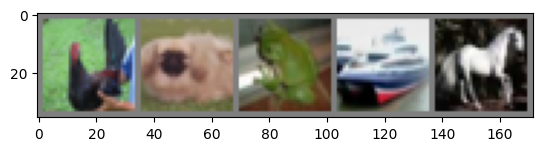

GroundTruth:  not dog, dog, not dog, not dog,
Predicted:  not dog, dog, not dog, not dog,


In [18]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Randomly select 5 images
indices = random.sample(range(len(images)), 5)
images, labels = images[indices], labels[indices]

# Show images
imshow(torchvision.utils.make_grid(images))

# Print ground truth
print('GroundTruth: ', ' '.join('dog,' if labels[j] == 1 else 'not dog,' for j in range(4)))

# Print predictions
outputs = net(images)
predicted = (outputs > 0.5).float()
print('Predicted: ', ' '.join('dog,' if predicted[j] == 1 else 'not dog,' for j in range(4)))
